# **Question 1- Find the similarity between two documents (2 corpus or two paragraphs) using any of the two similarity measures.**

In [40]:
import nltk
from nltk.corpus import gutenberg
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

In [41]:
# Download the Gutenberg Corpus if not already downloaded
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
# Select two books from the Gutenberg Corpus
book1 = gutenberg.raw('austen-emma.txt')
book2 = gutenberg.raw('austen-persuasion.txt')

In [43]:
# Toeknize the text
book1_tokens = word_tokenize(book1.lower())
book2_tokens = word_tokenize(book2.lower())

In [44]:
# Tokenize the text (convert it to set for Jaccard similarity)
book1_tokens_set = set(word_tokenize(book1.lower()))
book2_tokens_set = set(word_tokenize(book2.lower()))

In [45]:
# Remove stop words
stop_words = set(stopwords.words("english"))
book1_filtered_tokens = [word.lower() for word in book1_tokens if word.lower() not in stop_words]
book2_filtered_tokens = [word.lower() for word in book2_tokens if word.lower() not in stop_words]

In [46]:
# Stemming
stemmer = PorterStemmer()
book1_stemmed_tokens = [stemmer.stem(word) for word in book1_filtered_tokens]
book2_stemmed_tokens = [stemmer.stem(word) for word in book2_filtered_tokens]

In [47]:
# Convert to strings
book1_processed_text = " ".join(book1_stemmed_tokens)
book2_processed_text = " ".join(book2_stemmed_tokens)

In [48]:
# Vectorize the text
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform([book1_processed_text, book2_processed_text])

In [49]:
dense_tfidf_matrix = tfidf_matrix.toarray()

In [50]:
# Calculate Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])

print("Cosine Similarity:", cosine_sim)

Cosine Similarity: [[0.67869199]]


In [51]:
# Calculate Jaccard Similarity
intersection = len(book1_tokens_set.intersection(book2_tokens_set))
union = len(book1_tokens_set.union(book2_tokens_set))
jaccard_sim = intersection / union

print("Jaccard Similarity:", jaccard_sim)

Jaccard Similarity: 0.40471373659720816


In [52]:
# Calculate Jaccard Similarity
jaccard_sim = 1 - pairwise_distances(dense_tfidf_matrix[0:1], dense_tfidf_matrix[1:2], metric="jaccard")
print("Jaccard Similarity:", jaccard_sim)

Jaccard Similarity: [[0.45798035]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


# **Question 2- Implement the Sentiment Analysis using Bayesian Classification.**

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/DATASETS/Datafiniti_Hotel_Reviews.csv')

In [56]:
df.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-03T00:00:00Z,2016-07-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,NaN,NaN,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
1,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-02T00:00:00Z,2016-08-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,NaN,NaN,D,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
2,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-11-15T00:00:00Z,2016-08-23T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,NaN,NaN,Ron,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
3,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,"2016-05-21T00:00:00Z,2016-07-31T00:00:00Z",2.0,https://www.tripadvisor.com/Hotel_Review-g4118...,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",Richmond,VA,jaeem2016,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...
4,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,2016-07-31T00:00:00Z,5.0,https://www.tripadvisor.com/Hotel_Review-g4118...,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...,Laurel,MD,MamaNiaOne,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...


In [57]:
df.isnull().sum()

id                         0
dateAdded                  0
dateUpdated                0
address                    0
categories                 0
primaryCategories          0
city                       0
country                    0
keys                       0
latitude                   0
longitude                  0
name                       0
postalCode                 0
province                   0
reviews.date               0
reviews.dateSeen           0
reviews.rating             0
reviews.sourceURLs         0
reviews.text               1
reviews.title              1
reviews.userCity        5836
reviews.userProvince    7295
reviews.username           0
sourceURLs                 0
websites                   0
dtype: int64

In [58]:
df.shape

(10000, 25)

In [59]:
df = df.dropna(subset=['reviews.text'])

In [60]:
print(df['reviews.rating'])

0       5.0
1       5.0
2       5.0
3       2.0
4       5.0
       ... 
9995    3.0
9996    4.0
9997    4.0
9998    1.0
9999    1.0
Name: reviews.rating, Length: 9999, dtype: float64


In [61]:
df['reviews.rating'].unique()

array([5.  , 2.  , 4.  , 3.  , 1.  , 4.8 , 4.6 , 3.55, 4.4 , 4.15, 2.5 ,
       3.95, 2.9 , 3.35, 3.75, 4.5 , 2.1 , 1.65, 3.15, 2.7 , 1.45, 2.75,
       2.3 , 3.5 , 4.25, 1.25, 1.9 , 3.45, 3.25, 4.75])

In [62]:
# Map ratings to binary sentiment labels
df['sentiment'] = df['reviews.rating'].apply(lambda x: 0 if x <= 2 else 1)  # 0 for negative, 1 for positive

In [63]:
df.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites,sentiment
0,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,NaN,NaN,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,1
1,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,5.0,https://www.hotels.com/hotel/125419/reviews%20/,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,NaN,NaN,D,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,1
2,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,5.0,https://www.hotels.com/hotel/125419/reviews%20/,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,NaN,NaN,Ron,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com,1
3,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,2.0,https://www.tripadvisor.com/Hotel_Review-g4118...,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",Richmond,VA,jaeem2016,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...,0
4,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,5.0,https://www.tripadvisor.com/Hotel_Review-g4118...,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...,Laurel,MD,MamaNiaOne,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...,1


In [64]:
df.isnull().sum()

id                         0
dateAdded                  0
dateUpdated                0
address                    0
categories                 0
primaryCategories          0
city                       0
country                    0
keys                       0
latitude                   0
longitude                  0
name                       0
postalCode                 0
province                   0
reviews.date               0
reviews.dateSeen           0
reviews.rating             0
reviews.sourceURLs         0
reviews.text               0
reviews.title              1
reviews.userCity        5835
reviews.userProvince    7294
reviews.username           0
sourceURLs                 0
websites                   0
sentiment                  0
dtype: int64

In [65]:
X, Y = df['reviews.text'], df['sentiment']

In [66]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [67]:
# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [68]:
# Train the Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_vec, Y_train)

MultinomialNB()

In [69]:
# Predict sentiment on the test set
Y_pred = model.predict(X_test_vec)

In [70]:
# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9145


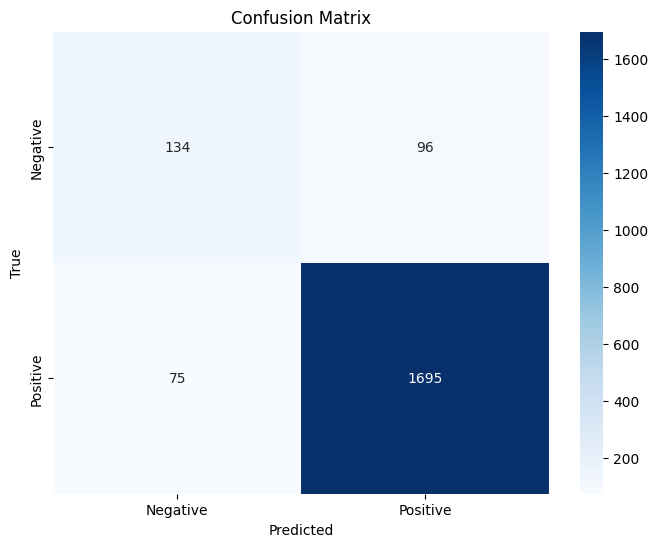

In [71]:
# Compute confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **Question 3- Implement the Sentiment Analysis using RNN.**

In [72]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, LSTM

In [73]:
# Tokenize text data
tokenizer = Tokenizer(num_words=100)  # Adjust num_words based on vocabulary size
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [74]:
# Pad sequences
maxlen = 100  # Adjust maxlen based on maximum sequence length
X_train_padded = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen)

In [75]:
# Build RNN model
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=128, input_length=maxlen))
model.add(SimpleRNN(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [76]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
# Train the model
history1 = model.fit(X_train_padded, Y_train, batch_size=32, epochs=5, validation_data=(X_test_padded, Y_test))

Epoch 1/5
250/250 [==============================] - 53s 201ms/step - loss: 0.3818 - accuracy: 0.8709 - val_loss: 0.3539 - val_accuracy: 0.8850
Epoch 2/5
250/250 [==============================] - 33s 130ms/step - loss: 0.3595 - accuracy: 0.8846 - val_loss: 0.3492 - val_accuracy: 0.8850
Epoch 3/5
250/250 [==============================] - 35s 140ms/step - loss: 0.3393 - accuracy: 0.8834 - val_loss: 0.3676 - val_accuracy: 0.8840
Epoch 4/5
250/250 [==============================] - 34s 137ms/step - loss: 0.3310 - accuracy: 0.8777 - val_loss: 0.3421 - val_accuracy: 0.8805
Epoch 5/5
250/250 [==============================] - 33s 132ms/step - loss: 0.3082 - accuracy: 0.8830 - val_loss: 0.2975 - val_accuracy: 0.8930


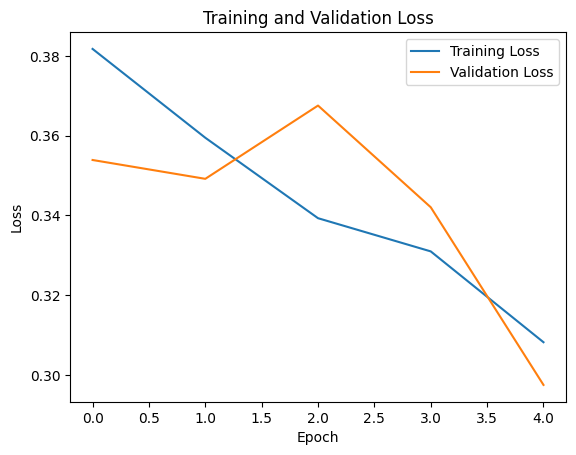

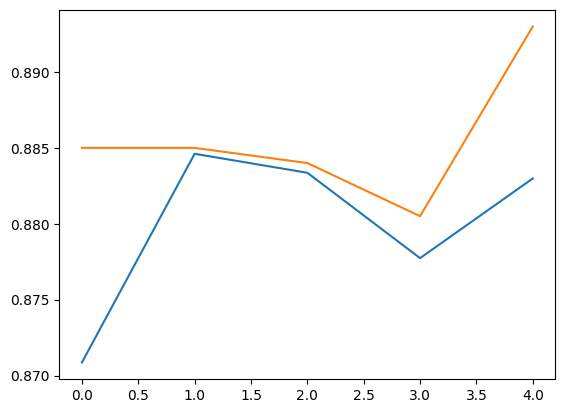

In [78]:
# Plot training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [79]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

63/63 [==============================] - 1s 10ms/step - loss: 0.2975 - accuracy: 0.8930
Test Loss: 0.29750651121139526
Test Accuracy: 0.8930000066757202


# **Question 4- Implement the Sentiment Analysis using LSTM.**

In [80]:
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=128, input_length=maxlen))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [81]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
history2 = model.fit(X_train_padded, Y_train, batch_size=32, epochs=5, validation_data=(X_test_padded, Y_test))

Epoch 1/5
250/250 [==============================] - 108s 417ms/step - loss: 0.3319 - accuracy: 0.8829 - val_loss: 0.2864 - val_accuracy: 0.8890
Epoch 2/5
250/250 [==============================] - 86s 342ms/step - loss: 0.2663 - accuracy: 0.8939 - val_loss: 0.2830 - val_accuracy: 0.8745
Epoch 3/5
 18/250 [=>............................] - ETA: 1:25 - loss: 0.2736 - accuracy: 0.8785

In [ ]:
# Plot training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)